In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from environment import Environment
from actor import DenseActor, RandomActor
from copy import deepcopy
from tqdm import tqdm
from utils import make_simulation_plot, run_environment_simulation, calculate_full_distance

In [2]:
n_samples_train = 500
n_samples_test = 50
n_locations = 5
n_steps = n_locations * 2
max_demand = 10
max_capacity = 50
n_epochs = 150
approximation_level = 10

dense_actor = DenseActor(n_locations)
random_actor = RandomActor(n_locations)
optimizer = tf.keras.optimizers.legacy.Adam()

env_org = Environment(n_samples_train, n_locations, max_demand, max_capacity)
env_test = Environment(n_samples_test, n_locations, max_demand, max_capacity)

In [ ]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = [
        [0, 548, 776, 696, 582],
        [548, 0, 684, 308, 194],
        [776, 684, 0, 992, 878],
        [696, 308, 992, 0, 114],
        [582, 194, 878, 114, 0],
    ]
    data["demands"] = [0, 2, 3, 2, 4]
    data["vehicle_capacities"] = [5, 5, 5, 5, 5]
    data["num_vehicles"] = 5
    data["depot"] = 0
    return data

In [3]:
grads_lst = []
losses_train = []
losses_test = []
losses_test_random = []

all_actions_real_train = []
all_actions_real_test = []
all_actions_real_random = []

all_actions_approximation_train = []
all_actions_approximation_test = []
all_actions_approximation_random = []

In [4]:
for _ in tqdm(range(n_epochs)):
    env_train_process = deepcopy(env_org)
    env_test_process = deepcopy(env_test)
    env_test_process_random = deepcopy(env_test)
    with tf.GradientTape(persistent=True) as tape:
        actions_approximation_train, actions_real_train = run_environment_simulation(
            env_train_process, dense_actor, n_steps, approximation_level
        )
        actions_approximation_test, actions_real_test = run_environment_simulation(
            env_test_process, dense_actor, n_steps, approximation_level
        )

        actions_approximation_test_random, actions_real_test_random = run_environment_simulation(
            env_test_process_random, random_actor, n_steps, approximation_level
        )

        full_distance_train = calculate_full_distance(tf.convert_to_tensor(actions_approximation_train))
        loss_train = tf.reduce_mean(full_distance_train)

        full_distance_test = calculate_full_distance(tf.convert_to_tensor(actions_approximation_test))
        loss_test = tf.reduce_mean(full_distance_test)

        full_distance_test_random = calculate_full_distance(tf.convert_to_tensor(actions_approximation_test_random))
        loss_test_random = tf.reduce_mean(full_distance_test_random)

        losses_train.append(loss_train)
        losses_test.append(loss_test)
        losses_test_random.append(loss_test_random)

    all_actions_approximation_train.append(actions_approximation_train)
    all_actions_approximation_test.append(actions_approximation_test)

    all_actions_real_train.append(actions_real_train)
    all_actions_real_test.append(actions_real_test)

    grads = tape.gradient(loss_train, dense_actor.trainable_variables)
    grads_and_vars = zip(grads, dense_actor.trainable_variables)
    optimizer.apply_gradients(grads_and_vars)
    grads_lst.append(grads)

100%|██████████| 150/150 [01:37<00:00,  1.53it/s]


In [5]:
tf_all_actions_approximation_train = tf.convert_to_tensor(all_actions_approximation_train)
tf_all_actions_approximation_test = tf.convert_to_tensor(all_actions_approximation_test)

tf_all_actions_real_train = tf.convert_to_tensor(all_actions_real_train)
tf_all_actions_real_test = tf.convert_to_tensor(all_actions_real_test)
# shape: [n_epochs x n_steps x n_samples x 2]

In [6]:
tf.reduce_mean(tf_all_actions_approximation_train - tf_all_actions_real_train)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.00012572567>

In [7]:
tf.reduce_mean(tf_all_actions_approximation_train - tf_all_actions_real_train)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.00012572567>

In [8]:
def fun(ls, n):
    return [np.mean(ls[i : i + n]) for i in range(0, len(ls) - n)]

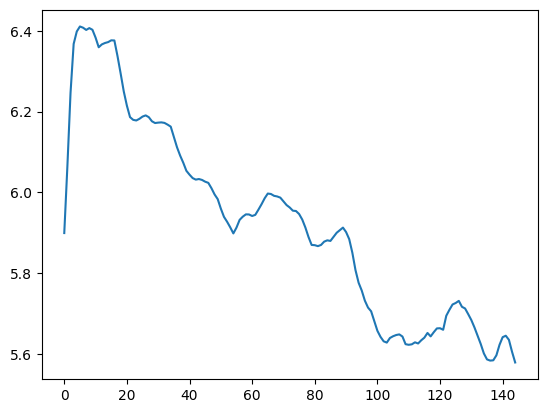

In [14]:
plt.plot(fun(losses_train, 5))
plt.show()

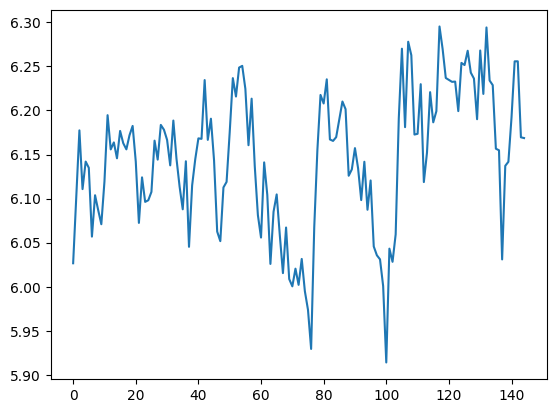

In [15]:
plt.plot(fun(losses_test_random, 5))
plt.show()

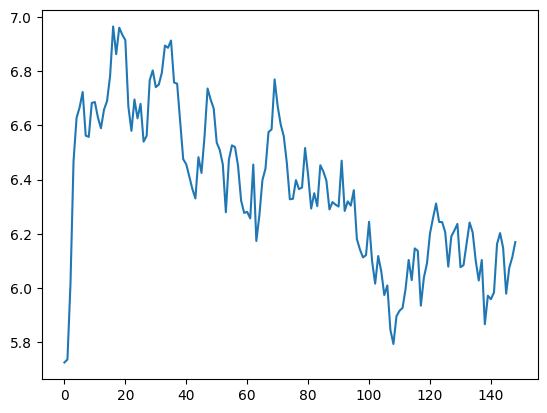

In [11]:
plt.plot(fun(losses_test, 1))
plt.show()
# plt.ylim([0, 250])

In [36]:
sample_id = 3

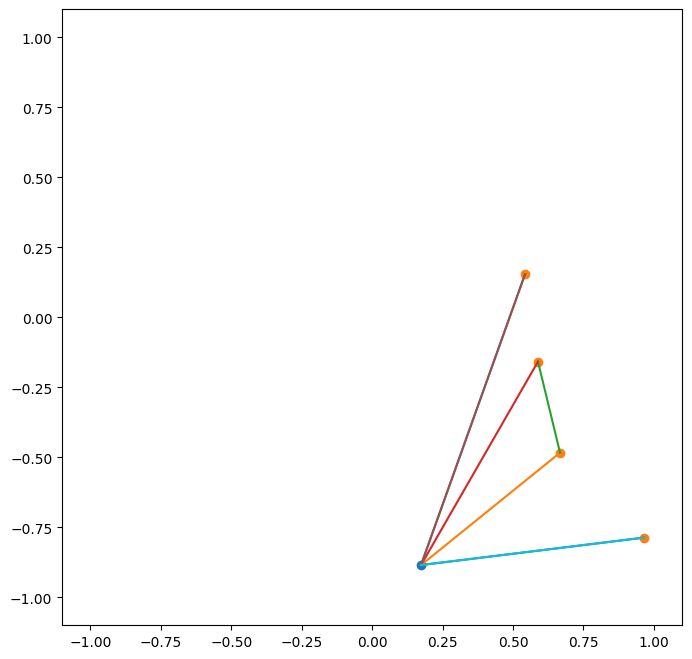

In [37]:
epoch_id = 0

# l1 = calculate_loss(tf_all_actions_real[epoch_id, :, sample_id:sample_id+1, :])
# print(l1.numpy())
make_simulation_plot(env_train_process.locations[sample_id], tf_all_actions_real_train[epoch_id, :, sample_id])

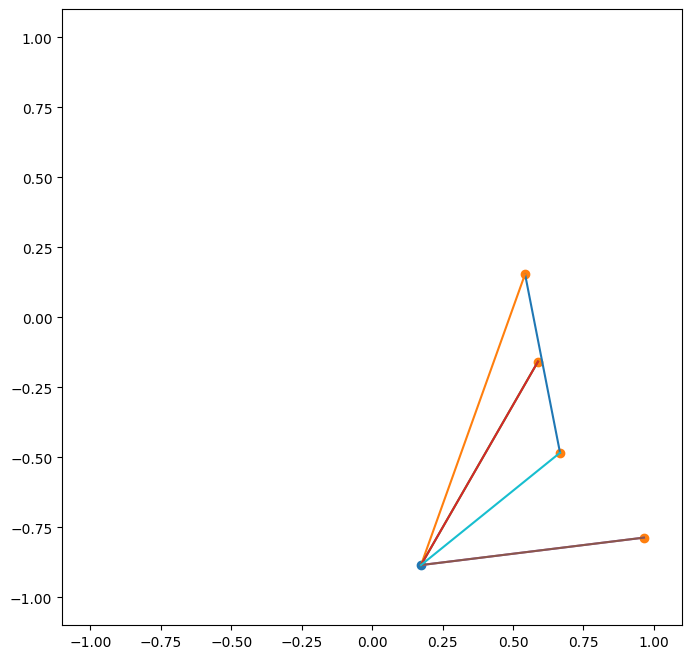

In [38]:
epoch_id = -1

# l1 = calculate_loss(tf_all_actions_real[epoch_id, :, sample_id:sample_id+1, :])
# print(l1.numpy())
make_simulation_plot(env_train_process.locations[sample_id], tf_all_actions_real_train[epoch_id, :, sample_id])